In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from numpy.random import seed
seed(7)

from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [2]:
df = pd.read_csv("processminer-rare-event-mts - data.csv") 
df.head(n=5)  # visualize the data.

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [3]:
df['y'].value_counts()[1]


124

In [4]:
df['y'].value_counts()[0]


18274

In [5]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [6]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 3 rows to do a 6-min ahead prediction.
df = curve_shift(df, shift_by = -3)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


,time,y,x1,x2,x3
256,5/1/99 8:32,0,1.016235,-4.058394,-1.097158
257,5/1/99 8:34,0,1.005602,-3.876199,-1.074373
258,5/1/99 8:36,0,0.933933,-3.868467,-1.249954
259,5/1/99 8:38,1,0.892311,-13.332664,-10.006578
260,5/1/99 10:50,0,0.020062,-3.987897,-1.248529


After shifting


,y,time,x1,x2,x3
255,0.0,5/1/99 8:30,0.997107,-3.865720,-1.133779
256,1.0,5/1/99 8:32,1.016235,-4.058394,-1.097158
257,1.0,5/1/99 8:34,1.005602,-3.876199,-1.074373
258,1.0,5/1/99 8:36,0.933933,-3.868467,-1.249954
260,0.0,5/1/99 10:50,0.020062,-3.987897,-1.248529


In [7]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

In [8]:
X = df.drop(['y'], axis=1)

y = df['y']

In [9]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((14619, 59), (3655, 59))

In [10]:
y_train

12510    0.0
7371     0.0
6997     0.0
12429    0.0
7338     0.0
        ... 
9288     0.0
13208    0.0
9912     0.0
10872    0.0
2758     0.0
Name: y, Length: 14619, dtype: float64

In [11]:
# Feature scaling

In [12]:
cols = X_train.columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])


In [13]:
# define model
model = XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.93120


In [13]:
model = XGBClassifier()
clf_0 = model.fit(X_train, y_train)

In [14]:
pred_y_0 = clf_0.predict(X_test)
print(accuracy_score(pred_y_0, y_test))

0.9830369357045143


In [15]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred_y_0, target_names=target_names))

# View confusion matrix for test data and predictions
confusion_matrix(y_test, pred_y_0)

              precision    recall  f1-score   support

     class 0       0.98      1.00      0.99      3586
     class 1       0.67      0.20      0.31        69

    accuracy                           0.98      3655
   macro avg       0.83      0.60      0.65      3655
weighted avg       0.98      0.98      0.98      3655



array([[3579,    7],
       [  55,   14]])

# Weighted XGBoost for Class Imbalance


In [17]:
# define model
#scale_pos_weight=total_negative_examples / total_positive_examples
#total number of examples in the majority class / total number of examples in the minority class.
#18274/124=147.37
model = XGBClassifier(scale_pos_weight=147)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.91696


In [18]:
clf_1 = model.fit(X_train, y_train)
pred_y_1 = clf_1.predict(X_test)

print(accuracy_score(pred_y_1, y_test))

0.986046511627907


In [19]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred_y_1, target_names=target_names))

# View confusion matrix for test data and predictions
confusion_matrix(y_test, pred_y_1)

              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      3608
     class 1       0.42      0.21      0.28        47

    accuracy                           0.99      3655
   macro avg       0.70      0.60      0.64      3655
weighted avg       0.98      0.99      0.98      3655



array([[3594,   14],
       [  37,   10]])

# Tune with GridSearch CV

In [21]:
# define grid
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)

In [22]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

In [33]:
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:03:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.931436 using {'scale_pos_weight': 1}
0.931436 (0.040774) with: {'scale_pos_weight': 1}
0.927670 (0.048305) with: {'scale_pos_weight': 10}
0.929479 (0.045071) with: {'scale_pos_weight': 25}
0.922069 (0.046362) with: {'scale_pos_weight': 50}
0.923126 (0.051366) with: {'scale_pos_weight': 75}
0.922714 (0.053929) with: {'scale_pos_weight': 99}
0.922413 (0.053952) with: {'scale_pos_weight': 100}
0.905774 (0.058887) with: {'scale_pos_weight': 1000}


In [23]:
# define model
model = XGBClassifier(scale_pos_weight=1000)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.90577


In [24]:
clf_2 = model.fit(X_train, y_train)
pred_y_2 = clf_2.predict(X_test)

print(accuracy_score(pred_y_2, y_test))



0.9849521203830369


In [25]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred_y_2, target_names=target_names))

# View confusion matrix for test data and predictions
confusion_matrix(y_test, pred_y_2)

              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99      3608
     class 1       0.41      0.40      0.41        47

    accuracy                           0.98      3655
   macro avg       0.70      0.70      0.70      3655
weighted avg       0.98      0.98      0.98      3655



array([[3581,   27],
       [  28,   19]])

<AxesSubplot:>

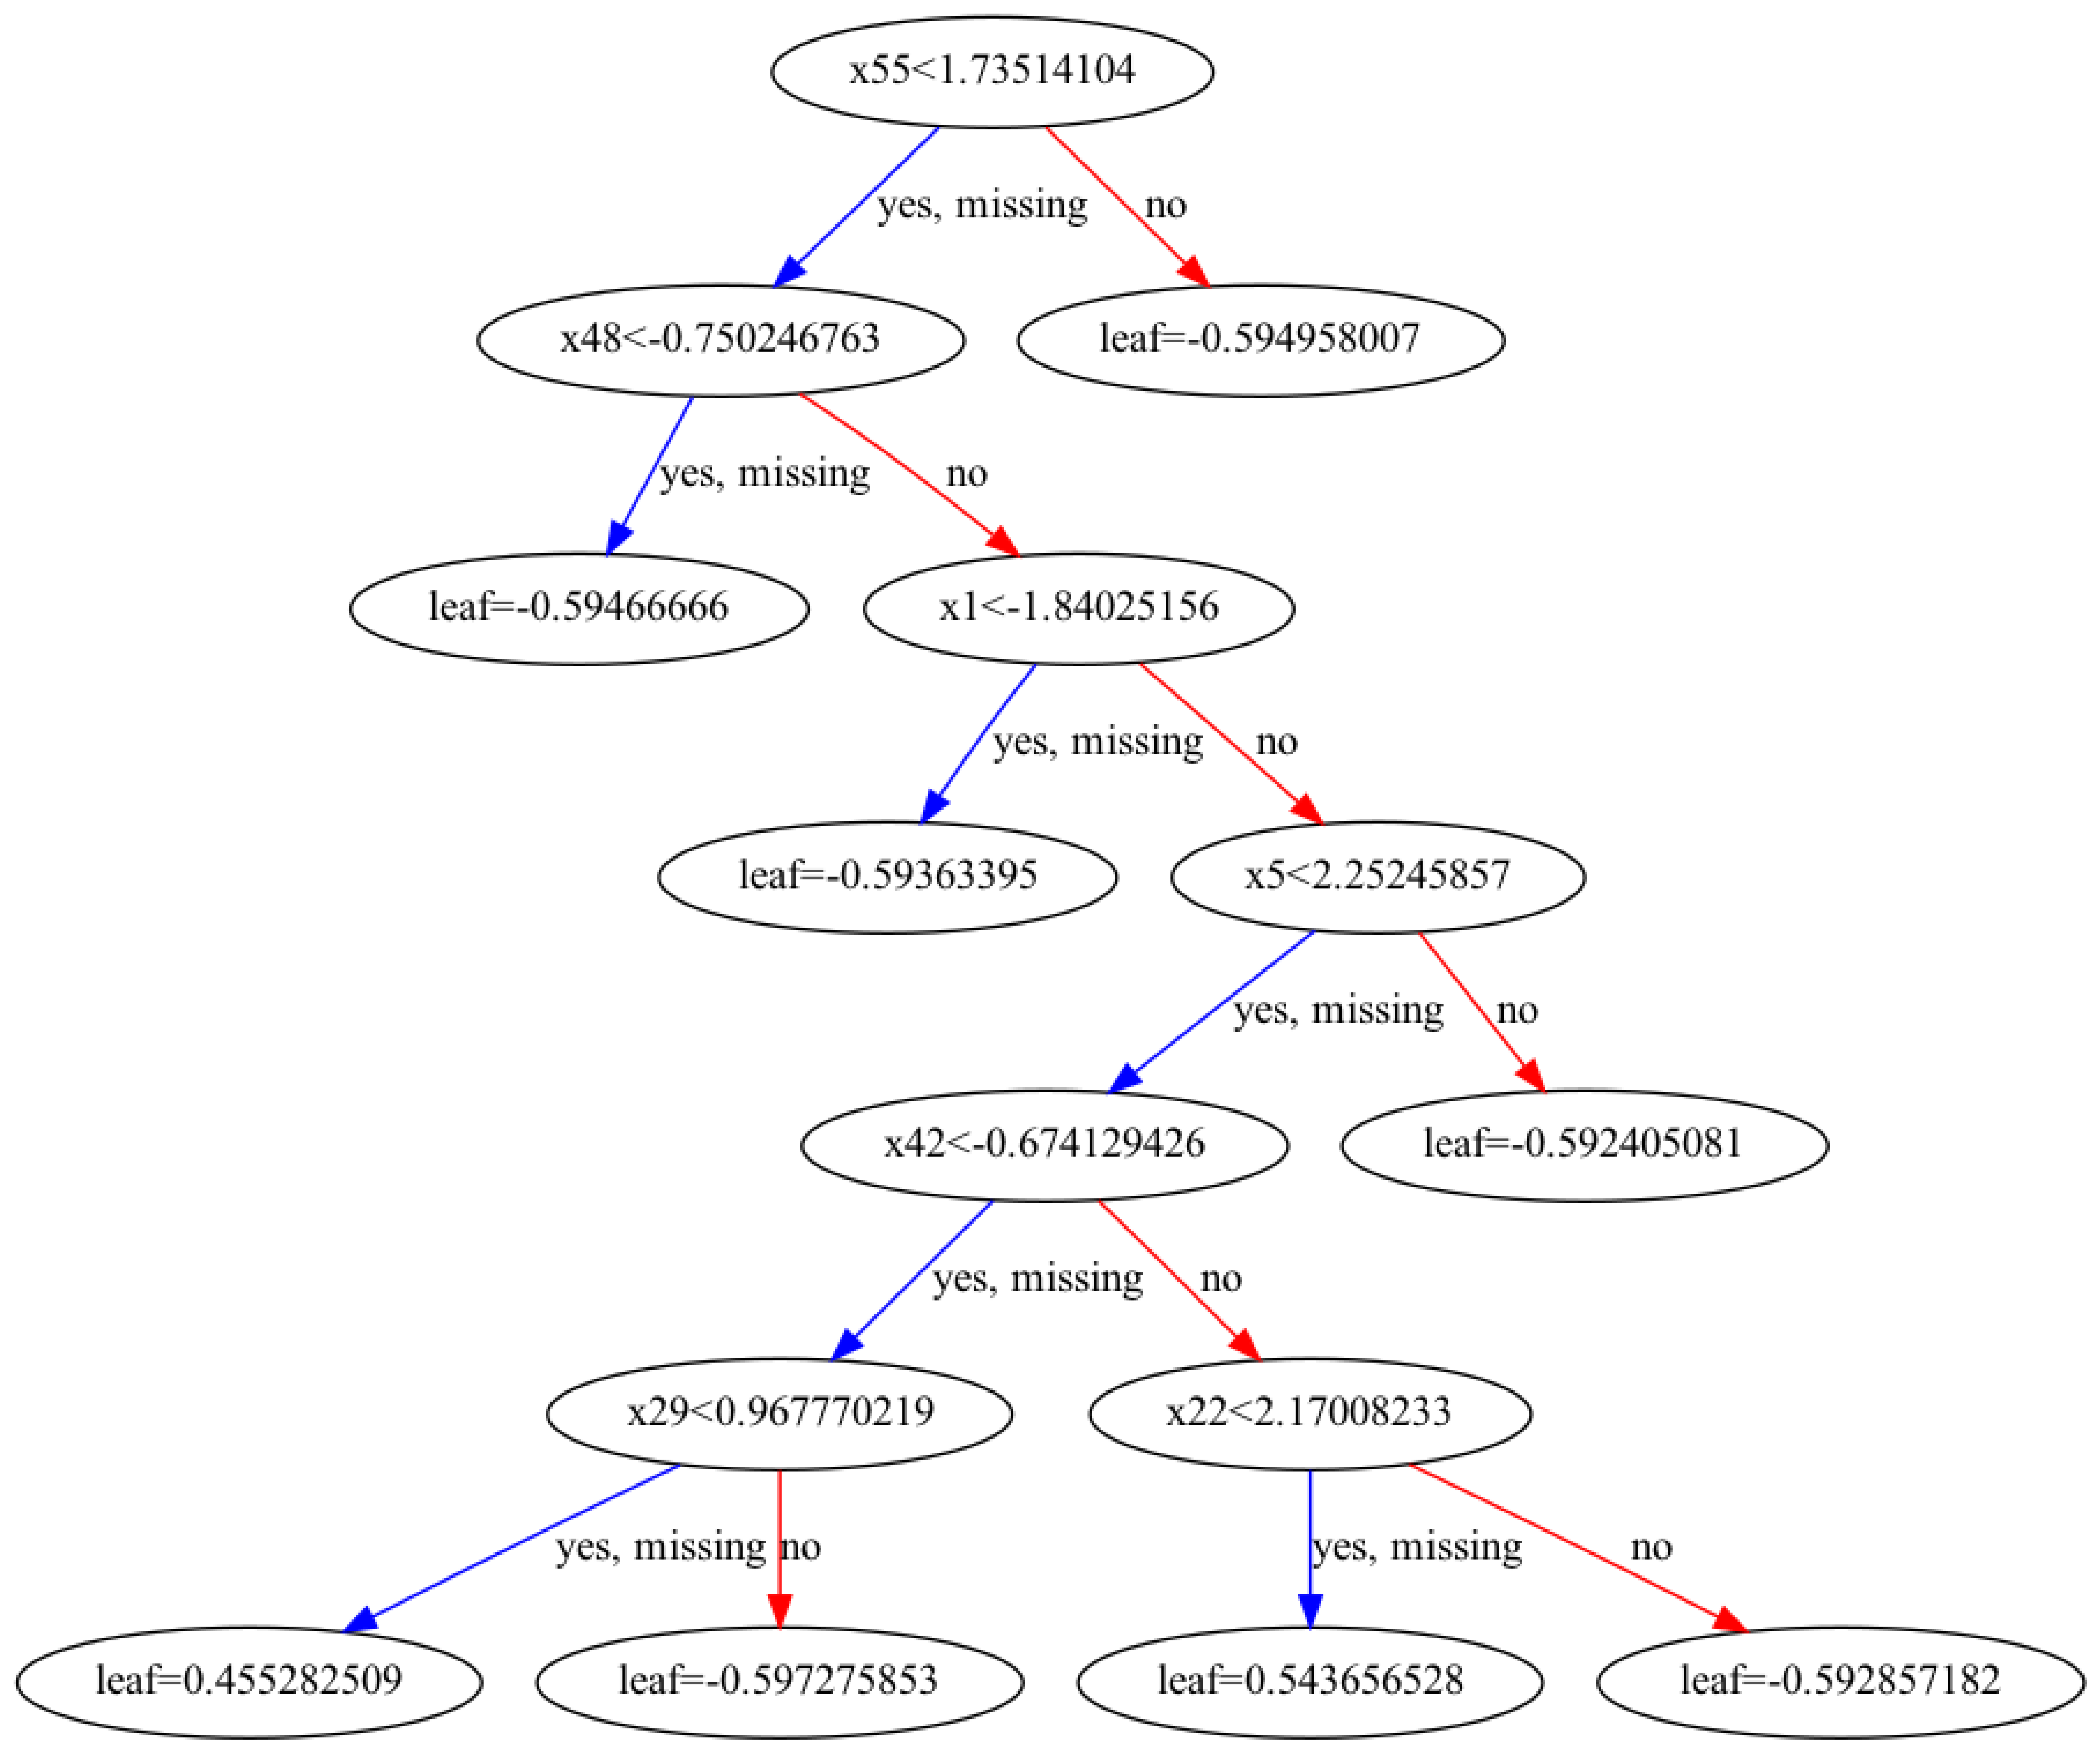

In [26]:
%matplotlib inline
from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80,50

plot_tree(model)
#yes, missing here means this tree has handled missing values